<h1><center>PHYS-F-303: Partie Numérique</center></h1>
<h1><center>Calcul détaillé des propriétés physiques pour le modèle d'Ising</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

## Question: Calculer la magnétisation moyenne pour différentes valeurs de $\alpha$ entre 0 et 1 et estimer la valeur de $\alpha$ critique

In [1]:
import time,numba,pandas
from numba import jit
from matplotlib import pyplot as plt
from pandas import DataFrame, read_csv
import numpy as np
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

### Calcul des paramètres (Magnétisation, Energie, Capacité calorifique) pour différents couplages

Nous étudions dans ce document une grille $20\times20$ de spins que l'on évolue selon l'algorithme "metropolis".

Nous exploitons la courbe de la capacité calorifique en fonction de du couplage $\alpha=J/kT$ pour déterminer le couplage de transition. Cette courbe doit présenter un pic à la valeur critique de couplage, voir "Computational Physics, J.M.Thijssen".

Nous calculons la capacité calorifique par la relation suivante, valable dans l'ensemble canonique:

$$ c_v = \frac{\text{var}(E)}{kT^2} $$

Les énergies étant déjà exprimées en unités de $J/kT$, nous pouvons porter la variance de l'énergie en fonction de alpha, cette quantité étant proportionelle à $c_v$.

Commençons par définir les fonctions nécessaires.

In [2]:
def initial_state_random(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [3]:
def initial_state_aligned(nx,ny):
    """ Creates a lattice with aligned spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    
    r = np.ones([nx,ny])
    
    return r

In [4]:
@jit
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]\
                         +sp[ix,(iy+1)%ny])

    return energy

In [5]:
@jit
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [6]:
@jit
def moy_magn(sp): 
    """ Computes the average magnetisation for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    M: average magnetisation for the lattice state sp 
    """
    
    M = sp.sum(axis=(0,1))/(len(sp)*len(sp[0]))
    return M

In [7]:
@jit
def moy_ener(sp,alpha): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energy for the lattice state sp 
    """
    
    pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
    pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
    pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
    pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
    E = -alpha * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                  + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
    E = E/(len(sp)*len(sp[0]))
           
    return E

In [8]:
@jit
def M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling constant for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    M: magnetisation 
    E: energie 
    """
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
        #if i%(int(NMC/10)+1)==0:
            #print("loop {:d} of {:d} for alpha = {:.2f}".format(i,NMC,alpha))
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
    return [M,E]

In [9]:
@jit
def M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq):
    """ Computes averages of physical quantities at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    Returns:
    -------
    Ms     : Vector of magnetisations at equilibrium for each alpha in alphas
    Es     : Vector of energis at equilibrium for each alpha in alphas
    VarEs  : Vector of the variances of the energy at equilibrium for each alpha in alphas
    """
    
    Ms  = np.empty([len(alphas)])
    Es  = np.empty([len(alphas)])
    VarEs = np.empty([len(alphas)])
    
    a = len(alphas)
    for i in range(a):
        
        print("loop {:d} of {:d}, at alpha = {:.3f}".format(i,a,alphas[i]))
        
        for j in range(NMC_eq):
            
            #if j%(int(NMC_eq/10)+1)==0:
                #print("loop {:d} of {:d} for alpha = {:.2f} (pre-equilibrium)".format(j,NMC_eq,alphas[i]))
            for j in range(0,nx*ny):
                ix = np.random.randint(0,nx)
                iy = np.random.randint(0,ny)
                metropolis_at_site(sps[i],alphas[i],ix,iy)
        
        [M_evol,E_evol] = M_with_time_for_alpha(sps[i],nx,ny,NMC,step,alphas[i])
        Ms[i]  = M_evol.sum()/len(M_evol)
        Es[i]  = E_evol.sum()/len(E_evol)
        VarEs[i] = (E_evol**2).sum()/len(E_evol) - (E_evol.sum()/len(E_evol))**2
        
        # save to file
        
        dataParam = list(zip(alphas[:i+1], Ms[:i+1], Es[:i+1], VarEs[:i+1]))
        df = pandas.DataFrame(data = dataParam, columns=['Couplage','<Magnetisation>', '<Energie>', 'Var(Energie)'])
        df.to_csv('dataIsing.csv',index=False,header=True)
    
    return [Ms,Es,VarEs]

L'initialisation des paramètres de la simulation se fait ici:

In [10]:
NMC = 100+70000
NMC_eq = 100
step = 1
nx = 20
ny = 20
alphas = np.concatenate((np.arange(0,0.34,0.02) , np.arange(0.34,0.41,0.005), np.arange(0.41,0.425,0.001) , \
                         np.arange(0.425,0.445,0.0003), np.arange(0.435,0.45,0.001), np.arange(0.45,0.56,0.005), \
                         np.arange(0.56,1,0.02)))
np.random.shuffle(alphas) # pour avoir des données utilisables en cours de simulation
a = len(alphas)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = initial_state_aligned(nx,ny)
    
print("Estimated computation time: {:.2f} hours".format(NMC/20000*a/92*1.00))

Estimated computation time: 6.67 hours


Exécuter la cellule suivante lance le calcul complet:

In [11]:
start = time.time()
#[Ms,Es,VarEs] = M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq)
stop = time.time()
print(stop-start)

8.034706115722656e-05


L'affichage des résulats se fait ici:

In [12]:
dataIsing = pandas.read_csv('dataIsing-3000-70000.csv')
[alphas, Ms, Es, VarEs] = np.transpose(dataIsing.as_matrix(['Couplage', '<Magnetisation>', \
                                                            '<Energie>', 'Var(Energie)']))

indices = np.argsort(alphas)
alphas = alphas[indices]
Ms = Ms[indices]
Es = Es[indices]
VarEs = VarEs[indices]

Cvs = VarEs

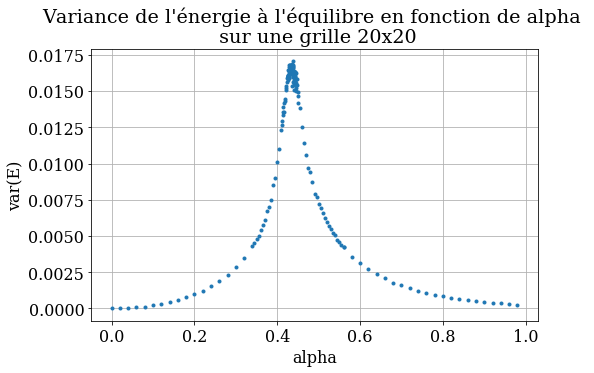

In [13]:
plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.title("Variance de l'énergie à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('var(E)');
#plt.xlim([0.41,0.46]);
plt.grid();
plt.show()

### Fit des données et recherche du maximum

In [14]:
def moindres_carres(x,y,a_test,b_test,c_test):
    """ Finds the best fitting parabola for the set of points (x,y)
   
    Parameters:
    ----------
    x : x-coordinates of the points to fit
    y : y-coordinates of the points to fit
    a_test : x^2 coefficent to be tested
    b_test : x^1 coefficent to be tested
    c_test : x^0 coefficent to be tested
    
    Returns:
    -------
    a : x^2 coefficent of the best fitting parabola
    b : x^1 coefficent of the best fitting parabola
    c : x^0 coefficent of the best fitting parabola
    """
    
    if len(x)!=len(y):
        print("x and y must have the same size")
        return
    
    N = len(x)
    
    # on calcule la sommes des erreurs au carré pour chaque parabole test
    S = np.zeros((len(a_test),len(b_test),len(c_test)))
    for i in range(len(a_test)):
        for j in range(len(b_test)):
            for k in range(len(c_test)):
                for l in range(N):
                    S[i,j,k] += (y[l] - (a_test[i]*x[l]**2+b_test[j]*x[l]+c_test[k]))**2
                
    # on cherche la parabole minimisant cette somme
    [i,j,k] = np.where(S==np.min(S))
    a = a_test[i[0]]
    b = b_test[j[0]]
    c = c_test[k[0]]
    
    # on renvoie une erreur si la parabole minimisante est une parabole limite (intervalle considéré trop petit)
    if (i==0)|(j==0)|(k==0)|(i==len(a_test)-1)|(j==len(b_test)-1)|(k==len(c_test)-1):
        print('The best fitting parabola is not one of the tested parabola, \
        try a wider range of coefficents')
        return [0,0,0]
    
    return [a,b,c]

Cherchons à la main les paramètres qui définissent une parabole proches des données sous la forme 

$$ y = A(x-X_0)^2+C $$

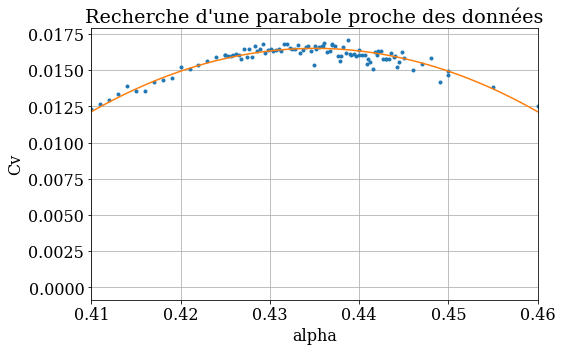

-7 0.435 0.0165


In [15]:
A = -7
X0 = 0.435
C = 0.0165

x = np.linspace(0.41,0.46,100)
y = A*(x-X0)**2+C

plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.plot(x,y, '-');
plt.title("Recherche d'une parabole proche des données".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('Cv');
plt.xlim([0.41,0.46]);
plt.grid();
plt.show()

print(A,X0,C)

Maintenant que nous savons parmi quels coefficients chercher, nous pouvons automatiser le processus avec la fonction cherchant par moindres carrés. Dans les cellules qui suivent, nous répétons plusieurs fois la recherche avec des données bruitées, afin de déterminer l'erreur sur le résultat trouvé pour l'absisse du maximum. Cette cellule affiche aussi les paramètres fittant le mieux chaque ensemble de données bruitées, ce qui nous permet d'affiner l'ensemble de paramètres test original. Les paramètres test sont bien choisi si l'erreur numérique liée à la finesse de l'échantillonage est petite comparée à l'erreur statistique sur les données récoltées. Ainsi, nous en arrivons à utiliser les paramètres test de la cellule qui suit.

In [16]:
indices = np.where((alphas>0.41)&(alphas<0.46))

A_test  = np.linspace(-7.17,-7.07,21)
X0_test = np.linspace(0.4335,0.435,21)
C_test  = np.linspace(0.0163,0.0166,21)

a_test = A_test
b_test = -2*A_test*X0_test
c_test = A_test*X0_test**2+C_test

[a_fit,b_fit,c_fit] = moindres_carres(alphas[indices],Cvs[indices],a_test,b_test,c_test)
a_fit = a_fit
b_fit = b_fit
c_fit = c_fit

A_fit  = a_fit
X0_fit = -b_fit/(2*a_fit)
C_fit  = c_fit - b_fit**2/(4*a_fit)
print(A_fit,X0_fit,C_fit)

x_max = -b_fit/(2*a_fit)
err_num = abs(C_test[1]-C_test[0])
print("Le maximum de la parabole de fit se trouve en x = {:.5f}".format(x_max))

-7.12 0.43425 0.01645
Le maximum de la parabole de fit se trouve en x = 0.43425


Nous cherchons l'erreur sur le maximum en refittant plusieurs fois sur les données bruitées.
Nous ajoutons pour cela un bruit d'amplitude plausible sur les données. 

In [17]:
repet = 10
x_max_vec = np.zeros((repet))

for i in range(repet):
    
    print("loop {:d} of {:d}".format(i,repet))
    
    Cvs_bruit = Cvs + np.random.uniform(-1,1,len(VarEs))*3e-4 # amplitude plausible

    indices = np.where((alphas>0.41)&(alphas<0.46))

    A_test  = np.linspace(-7.17,-7.07,21)
    X0_test = np.linspace(0.4335,0.435,21)
    C_test  = np.linspace(0.0163,0.0166,21)

    a_test = A_test
    b_test = -2*A_test*X0_test
    c_test = A_test*X0_test**2+C_test

    [a_fit,b_fit,c_fit] = moindres_carres(alphas[indices],Cvs_bruit[indices],a_test,b_test,c_test)
    a_fit = a_fit
    b_fit = b_fit
    c_fit = c_fit

    A_fit  = a_fit
    X0_fit = -b_fit/(2*a_fit)
    C_fit  = c_fit - b_fit**2/(4*a_fit)
    print(A_fit,X0_fit,C_fit)

    x_max_vec[i] = -b_fit/(2*a_fit)
    
err_num   = abs(C_test[1]-C_test[0])
err_stat  = np.std(x_max_vec)
err_x_max = np.sqrt(err_stat**2 + err_num**2)
    
print("--------------------------------------------------------------------")
print("Le maximum de la parabole de fit se trouve en x = {:.5f} +- {:.5f}".format(x_max, err_x_max))
print("Erreur numérique: {:.5f} - Erreur Statistique: {:.5f}".format(err_num,err_stat))
print("--------------------------------------------------------------------")

loop 0 of 10
-7.11 0.4344 0.01648
loop 1 of 10
-7.12 0.43425 0.01645
loop 2 of 10
-7.125 0.434175 0.016435
loop 3 of 10
-7.135 0.433795795375 0.0164654765261
loop 4 of 10
-7.125 0.434175 0.016435
loop 5 of 10
-7.12 0.43425 0.01645
loop 6 of 10
-7.12 0.43425 0.01645
loop 7 of 10
-7.12 0.43425 0.01645
loop 8 of 10
-7.12 0.43425 0.01645
loop 9 of 10
-7.135 0.433795795375 0.0164654765261
--------------------------------------------------------------------
Le maximum de la parabole de fit se trouve en x = 0.43425 +- 0.00019
Erreur numérique: 0.00002 - Erreur Statistique: 0.00019
--------------------------------------------------------------------


Affichons le fit final

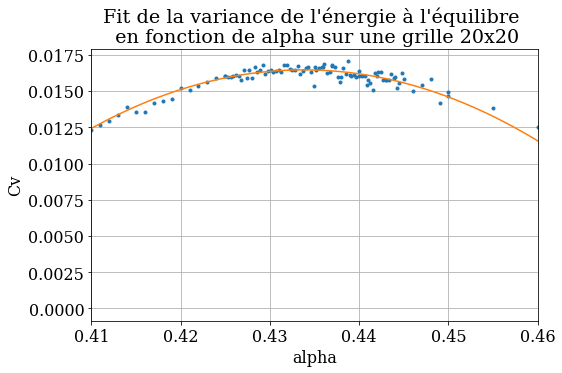

In [18]:
x = np.linspace(0.41,0.46,100)
y_fit = a_fit*x**2+b_fit*x+c_fit

plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.plot(x,y_fit, '-');
plt.title("Fit de la variance de l'énergie à l'équilibre \n en fonction de alpha sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('Cv');
plt.xlim([0.41,0.46]);
plt.grid();
plt.show()